In [ ]:
#로컬 런타임 연결 후 실행

In [7]:
#트럭 객체 추출 모델 : facebook/detr-resnet-50

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw, ImageFont
import requests

#image = Image.open("D:/차량번호판인식프로젝트/data/test/truck/fc3b67ba-4015-4b80-83ea-ec365cca257c.jpg")
image = Image.open("D:/차량번호판인식프로젝트/data/test/truck/f89ffcc5-5836-4314-92d3-41619f0defa5.jpg")

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
    #Object 테두리 그리기
    draw = ImageDraw.Draw(image)
    draw.rectangle((box[0], box[1], box[2], box[3]),  outline=(0,255,0),width=3)
    draw.text(((box[0]+10),box[1]),model.config.id2label[label.item()]+":"+str(round(score.item(), 3)),  fill=(0,255, 0 ), font=ImageFont.truetype("arial.ttf",size=20))

Detected truck with confidence 0.992 at location [1014.3, 184.1, 1279.35, 524.52]
Detected truck with confidence 0.997 at location [513.92, 345.2, 866.23, 591.5]
Detected person with confidence 0.996 at location [717.62, 512.49, 757.88, 628.95]


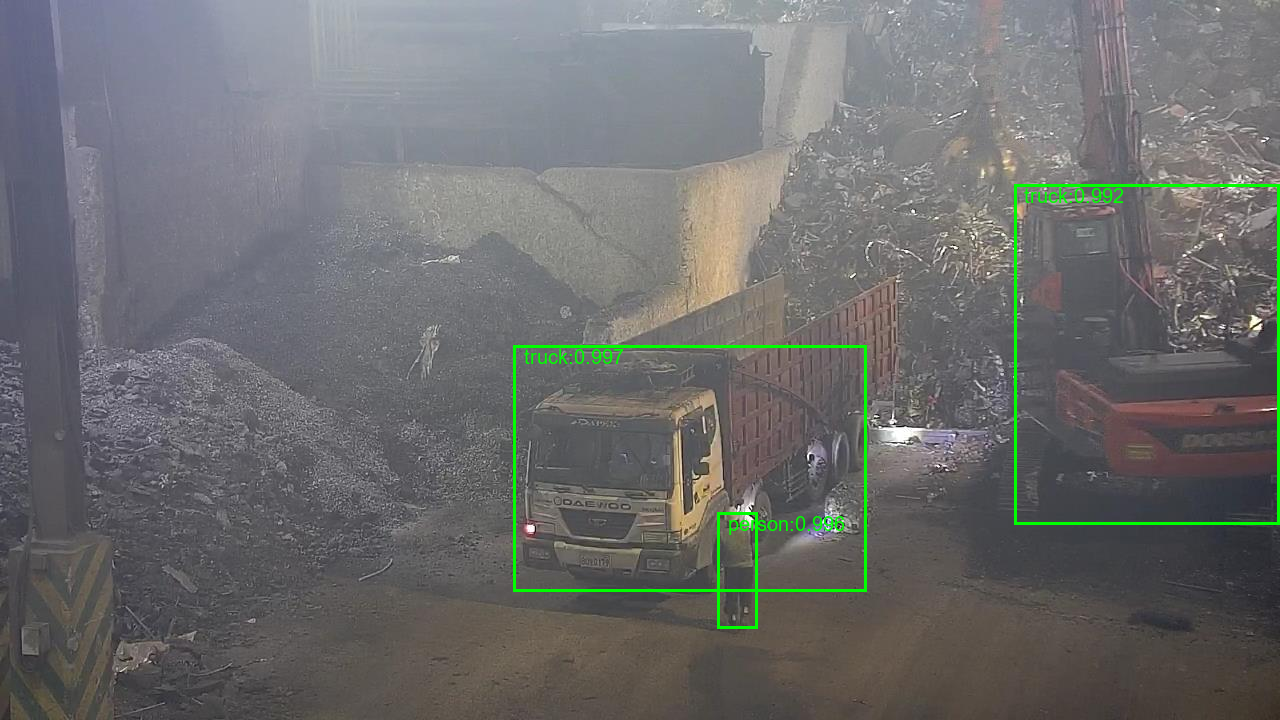

In [11]:
image

In [ ]:
# 번호판 객체 추출 모델 : keremberke/yolov5m-license-plate
# pip install -U yolov5

YOLOv5  2023-12-19 Python-3.9.0 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


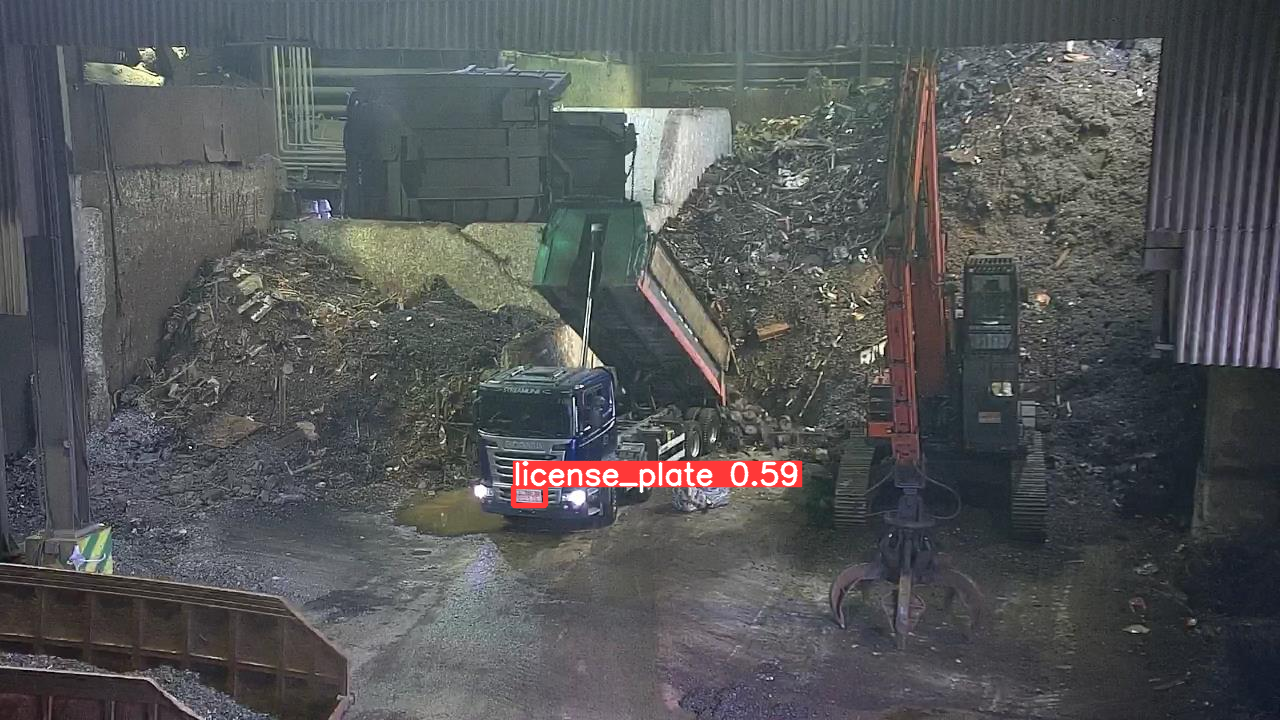

In [12]:
import yolov5
from PIL import Image, ImageDraw, ImageFont

# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
img = Image.open("D:/차량번호판인식프로젝트/data/test/truck/fc3b67ba-4015-4b80-83ea-ec365cca257c.jpg")

# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# threshold = 0.7
# filtered_indices = scores > threshold
# boxes = boxes[filtered_indices]

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

In [13]:
# 번호판 사진만 자르기
rounded_boxes = boxes.cpu().numpy()
img_crop = img.crop((rounded_boxes[0][0], rounded_boxes[0][1], rounded_boxes[0][2], rounded_boxes[0][3]))
img_crop

In [ ]:
# 번호판 탐지 및 crop
import yolov5
import os
import glob

# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image


total_dir = os.listdir("d:/TechTri/data")
cnt = 0


for date in total_dir:
  date_directory = "d:/TechTri/data/"+date
  i_url = date_directory+'/'
  li = os.listdir(date_directory)
  sub_dir_name = ["차량번호인식","고철 A 차량번호","고철 B 차량번호","차량번호"]
  for l in li:
    if(cnt>600):
      break
    for i in range(4):
      i_path = i_url+l+"/"+sub_dir_name[i]
      if(os.path.isdir(i_path)):
        url = os.listdir(i_path)
        files = os.listdir(i_path)
        path = i_path + "/"
        for name in files:

          url = path+name
          # set image
          img = Image.open(url)

          # perform inference
          results = model(img, size=640)

          # inference with test time augmentation
          results = model(img, augment=True)

          # parse results
          predictions = results.pred[0]
          boxes = predictions[:, :4] # x1, y1, x2, y2
          scores = predictions[:, 4]
          categories = predictions[:, 5]

          # show detection bounding boxes on image
          if (len(boxes) > 0) and scores[0]>=0.7:
              # Get the coordinates of the first bounding box
              x1, y1, x2, y2 = map(int, boxes[0])

              # Crop the license plate region from the original image
              license_plate_img = img.crop((x1, y1, x2, y2))

              # Save or display the cropped license plate image
              license_plate_img.save("d:/TechTri/license_plate_crop/"+name,'JPEG')
              cnt+=1
              print("success: "+str(cnt))

In [ ]:
# 번호판 숫자 인식 model : easyocr
# pip install easyocr

In [25]:
#이미지 크기 키우기
def resize_image(image, new_size=(800, 600)):
    img = image
    img = img.resize(new_size)
    return img

In [23]:
image = Image.open('D:/차량번호판인식프로젝트/license_plate_crop/0b73841f-0f46-4d2c-86c7-3558b4f5cc7c.jpg')
resized_image = resize_image(image)
resized_image.save('d:/차량번호판인식프로젝트/resize/3.png')

In [26]:
import easyocr
reader = easyocr.Reader(['ko','en'])
results = reader.readtext('d:/차량번호판인식프로젝트/resize/2.png', detail = 0)
print(results)
results = reader.readtext('d:/차량번호판인식프로젝트/license_plate_crop/00d7534c-3730-45a9-a453-1bd3a75acbde.jpg', detail = 0)
print(results)

['Bull']
[]
